In [1]:
# 导入所有的库
%matplotlib inline
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Numbers of training images:" + str(x_train.shape[0]))
print("Numbers of testing images:" + str(x_test.shape[0]))

Numbers of training images:60000
Numbers of testing images:10000


In [3]:
# 数据预处理函数定义
def data_processing(x, y):
    def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i])] = 1
        return table

    def normalize(x):
        x = x / 255
        k, m, n = x.shape[0], x.shape[1], x.shape[2]
        x = x.reshape(k, m * n)
        x = x.astype('float32')
        return x

    return normalize(x), one_hot(y)

In [4]:
# 进行数据集格式预处理
x_train, y_train = data_processing(x_train, y_train)
x_test, y_test = data_processing(x_test, y_test)

In [5]:
# 检验导入并预处理过的数据集
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)


In [6]:
# 搭建两层神经网络模型

class TwoLayerNeuralNetwork:
    def __init__(self, x, y, hidden_cells=128, batch=64, lr=5e-3, epochs=50, lambd=0.01, decay_rate=0.01):
        self.input = x
        self.target = y
        self.hidden_cells = hidden_cells
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.lambd = lambd
        self.decay_rate = decay_rate

        self.x = self.input[:self.batch]  # batch输入
        self.y = self.target[:self.batch]  # batch标签
        self.loss = []  # loss
        self.acc = []  # accuracy

        self.init_weights()

    def init_weights(self):  # 这里的几个w和b设置初始化，后面要改的
        self.w1 = np.random.randn(
            self.input.shape[1], self.hidden_cells)  # 设置的hidden_size
        self.w2 = np.random.randn(self.w1.shape[1], self.y.shape[1])  # 这里要重新填

        self.b1 = np.random.randn(self.w1.shape[1],)
        self.b2 = np.random.randn(self.w2.shape[1],)

    def ReLU(self, x):
        return np.maximum(0, x)

    def dReLU(self, x):
        return 1 * (x > 0)

    def softmax(self, z):
        z = z - np.max(z, axis=1).reshape(z.shape[0], 1)
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(z.shape[0], 1)

    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]

    def feedforward(self):
        assert self.x.shape[1] == self.w1.shape[0]
        self.z1 = self.x.dot(self.w1) + self.b1
        self.a1 = self.ReLU(self.z1)

        assert self.a1.shape[1] == self.w2.shape[0]
        self.z2 = self.a1.dot(self.w2) + self.b2
        self.a2 = self.softmax(self.z2)

    def cross_entropy_loss(self):
        delta = 1e-7  # 添加delta保证log有效性
        cross_entropy_cost = - \
            np.sum(np.multiply(self.y, np.log(self.a2 + delta)))
        return cross_entropy_cost / self.y.shape[0]

    # def cross_entropy_loss(self):
    #     a2 = self.a2
    #     y = self.y
    #     if a2.ndim == 1:
    #         a2 = a2.reshape(1, a2.size)
    #         y = y.reshape(1, y.size)

    #     if a2.size == y.size:
    #         y = y.argmax(axis=1)

    #     batch_size = y.shape[0]
    #     return -np.sum(np.log(a2[np.arange(batch_size), y] + 1e-7)) / batch_size

    def backprop(self):  # 反向传播
        self.error = self.a2 - self.y  # error
        self.dcost = (1 / self.batch) * self.error  # dcost

        self.dw2 = np.dot(self.dcost.T, self.a1).T + \
            self.lambd * self.w2  # 添加l2正则化项
        self.dw1 = np.dot((np.dot((self.dcost), self.w2.T) *
                           self.dReLU(self.z1)).T, self.x).T + self.lambd * self.w1  # 添加l2正则化项
        self.db2 = np.sum(self.dcost, axis=0)
        self.db1 = np.sum(np.dot((self.dcost), self.w2.T)
                          * self.dReLU(self.z1), axis=0)

    def optimizer(self, epoch):  # 使用SGD方法
        assert self.dw2.shape == self.w2.shape
        assert self.dw1.shape == self.w1.shape

        assert self.db2.shape == self.b2.shape
        assert self.db1.shape == self.b1.shape

        self.weight_decay = 1 / (1 + self.decay_rate * epoch)

        self.w2 = self.w2 - self.lr * self.weight_decay * self.dw2
        self.w1 = self.w1 - self.lr * self.weight_decay * self.dw1

        self.b2 = self.b2 - self.lr * self.weight_decay * self.db2
        self.b1 = self.b1 - self.lr * self.weight_decay * self.db1
        

    def train(self, IS_PRINT=False):
        for epoch in range(self.epochs):
            loss = 0
            loss_penalty = 0
            acc = 0
            self.shuffle()

            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch + 1) * self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.feedforward()
                self.backprop()
                self.optimizer(epoch)
                loss += np.mean(self.error**2)  # 均方loss
                loss_penalty += (np.sum(np.square(NN.w1)) +
                                 np.sum(np.square(NN.w2))) * (NN.lambd / 2) / 64
                acc += np.count_nonzero(np.argmax(self.a2, axis=1)
                                        == np.argmax(self.y, axis=1)) / self.batch
            # print("Loss_MSE:", loss)
            # print("Loss_Penalty:", loss)
            self.loss.append(
                loss_penalty / self.input.shape[0] + loss / (self.input.shape[0] // self.batch))
            self.acc.append(acc * 100 / (self.input.shape[0] // self.batch))
            if (IS_PRINT):
                print("Epoch:\t", epoch+1, "\tLoss:\t",
                      self.loss[epoch], "\tAccuracy:\t", self.acc[epoch], '%')
            # 保存模型
            self.save_model(f"model_{self.hidden_cells}_{self.lr}_{self.lambd}.npz")

    def test(self, x_test, y_test):
        self.x = x_test
        self.y = y_test
        self.feedforward()

        acc = np.count_nonzero(np.argmax(self.a2, axis=1)
                               == np.argmax(self.y, axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, '%')
        return 100 * acc

    def save_model(self, filename):
        np.savez_compressed(
            file = os.path.join(os.curdir, 'models', filename),
            w1 = self.w1,
            w2 = self.w2,
            b1 = self.b1,
            b2 = self.b2,
        )

    def load_models(self, filename):
        params = np.load(os.path.join(os.curdir, 'models', filename), allow_pickle=True)
        self.w1 = params['w1']
        self.w2 = params['w2']
        self.b1 = params['b1']
        self.b2 = params['b2']

    def plot_loss(self):
        plt.plot(self.loss)

    def plot_acc(self):
        plt.plot(self.acc)

In [7]:
# 定义模型 & 训练模型
NN = TwoLayerNeuralNetwork(
    x_train, y_train, hidden_cells=128, batch=64, lr=0.05, epochs=50, lambd=0.001, decay_rate=0)
NN.train(IS_PRINT=True)

Epoch:	 1 	Loss:	 0.050235346258034975 	Accuracy:	 79.47238527214515 %
Epoch:	 2 	Loss:	 0.03307255642507519 	Accuracy:	 87.25653681963713 %
Epoch:	 3 	Loss:	 0.028428947822841097 	Accuracy:	 88.83904749199573 %
Epoch:	 4 	Loss:	 0.02521657707435789 	Accuracy:	 89.76787620064034 %
Epoch:	 5 	Loss:	 0.022629935817514095 	Accuracy:	 90.63667289220918 %
Epoch:	 6 	Loss:	 0.020686860205890847 	Accuracy:	 91.15861792956244 %
Epoch:	 7 	Loss:	 0.018944042959380958 	Accuracy:	 91.83397812166488 %
Epoch:	 8 	Loss:	 0.017426823739863314 	Accuracy:	 92.33424493062967 %
Epoch:	 9 	Loss:	 0.016143082008620212 	Accuracy:	 92.8962113127001 %
Epoch:	 10 	Loss:	 0.014983573502898518 	Accuracy:	 93.31310032017076 %
Epoch:	 11 	Loss:	 0.014005474950134066 	Accuracy:	 93.6449439701174 %
Epoch:	 12 	Loss:	 0.01317465988425069 	Accuracy:	 93.92509338313768 %
Epoch:	 13 	Loss:	 0.012369889545415 	Accuracy:	 94.17522678762006 %
Epoch:	 14 	Loss:	 0.011704658979467689 	Accuracy:	 94.49372998932765 %
Epoch:	 1

In [ ]:
# 参数查找
hidden_cells_nums = [32, 64, 128]
lrs = [0.05, 0.01, 0.005]
lambds = [0, 0.001, 0.01]

In [ ]:
best_config = {'accuracy' : 0}
for hidden_cells_num in hidden_cells_nums:
    for lr in lrs:
        for lambd in lambds:
            print(f"*****hidden_cells:{hidden_cells_num},learning_rate:{lr},lambds:{lambd}")
            model = TwoLayerNeuralNetwork(x_train, y_train,hidden_cells=hidden_cells_num, batch=64, lr=lr, epochs=50, lambd=lambd)
            model.train(IS_PRINT=True)
            accuracy = self.acc[-1]
            print("accuracy:", accuracy)
            if accuracy > best_config['accuracy']:
                best_config['accuracy'] = accuracy
                best_config['hidden_cells'] = hidden_cells_num
                best_config['learning_rate'] = lr
                best_config['lambd'] = lambd
            

In [ ]:
model = TwoLayerNeuralNetwork(x_train, y_train,hidden_cells=hidden_cells_num, batch=64, lr=lr, epochs=50, lambd=lambd)
model.load_model(filename) # 这里填写对应的文件名

In [ ]:
# 利用测试集测试准确率
NN.test(x_test, y_test)

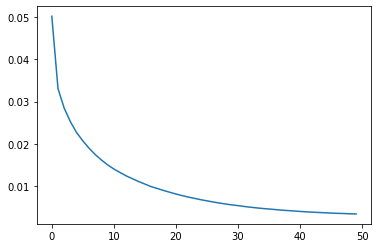

In [8]:
# loss可视化
NN.plot_loss()

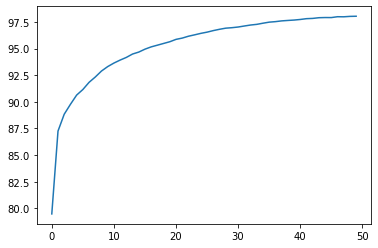

In [9]:
# acc可视化
NN.plot_acc()

(array([8.0000e+00, 8.2000e+01, 1.1230e+03, 7.3020e+03, 2.3868e+04,
        3.4996e+04, 2.4159e+04, 7.6000e+03, 1.1280e+03, 8.6000e+01]),
 array([-0.49938874, -0.40897452, -0.31856029, -0.22814607, -0.13773184,
        -0.04731762,  0.04309661,  0.13351083,  0.22392506,  0.31433928,
         0.40475351]),
 <BarContainer object of 10 artists>)

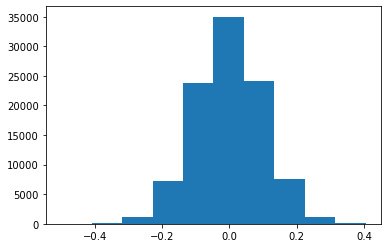

In [11]:
plt.hist(NN.w1.flatten().tolist())

(array([ 2.,  5.,  9., 10., 23., 20., 24., 18.,  9.,  8.]),
 array([-2.40965858, -1.9866888 , -1.56371902, -1.14074924, -0.71777945,
        -0.29480967,  0.12816011,  0.55112989,  0.97409967,  1.39706945,
         1.82003923]),
 <BarContainer object of 10 artists>)

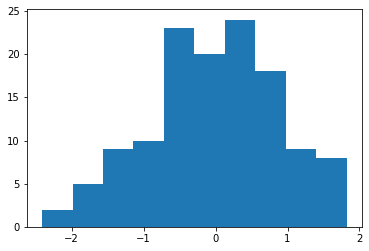

In [12]:
plt.hist(NN.b1.flatten().tolist())

(array([  1.,  16.,  46., 127., 317., 387., 232.,  94.,  53.,   7.]),
 array([-0.93201928, -0.75856966, -0.58512004, -0.41167042, -0.2382208 ,
        -0.06477118,  0.10867844,  0.28212807,  0.45557769,  0.62902731,
         0.80247693]),
 <BarContainer object of 10 artists>)

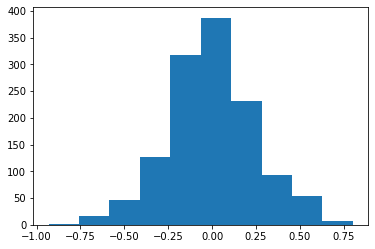

In [13]:
plt.hist(NN.w2.flatten().tolist())

(array([3., 0., 3., 1., 1., 1., 0., 0., 0., 1.]),
 array([-1.49520812, -1.13593309, -0.77665806, -0.41738303, -0.058108  ,
         0.30116703,  0.66044206,  1.01971709,  1.37899211,  1.73826714,
         2.09754217]),
 <BarContainer object of 10 artists>)

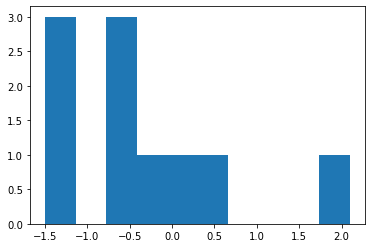

In [14]:
plt.hist(NN.b2.flatten().tolist())